In [1]:
import os
from PIL import Image

image = Image.open('sample.jpg')

# Get the dimensions of the image
width, height = image.size

crop_width = 700
crop_height = 900

# Calculate the coordinates for cropping
left = (width - crop_width) // 2
top = (height - crop_height) // 2
right = left + crop_width
bottom = top + crop_height

# Crop the image
cropped_image = image.crop((left, top, right, bottom))

cropped_image.save('crop.jpg')

# Close the image
image.close()

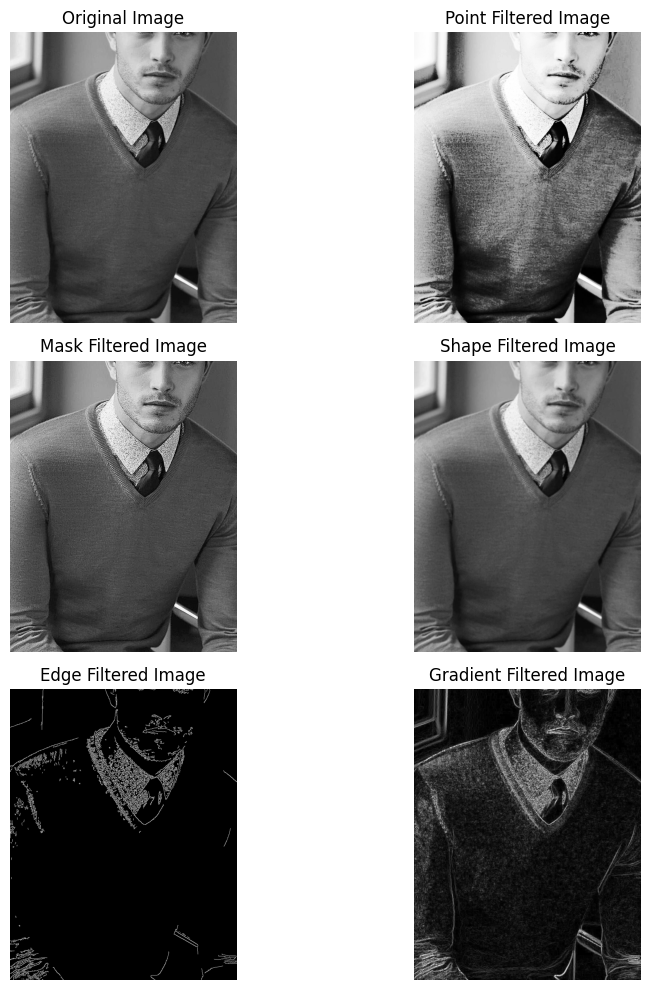

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image, technique):
    if technique == "point":
        # Apply point preprocessing technique
        filtered_image = cv2.equalizeHist(image)
    elif technique == "mask":
        # Apply mask preprocessing technique
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=np.float32)
        filtered_image = cv2.filter2D(image, -1, kernel)
    elif technique == "shape":
        # Apply shape preprocessing technique (blur)
        filtered_image = cv2.GaussianBlur(image, (5, 5), 0)
    elif technique == "edge":
        # Apply edge preprocessing technique
        filtered_image = cv2.Canny(image, 100, 200)
    elif technique == "gradient":
        # Apply gradient preprocessing technique (Sobel)
        gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        filtered_image = np.uint8(gradient_magnitude)
    else:
        raise ValueError("Invalid preprocessing technique provided")

    return filtered_image

# Load image
image = cv2.imread("crop.jpg", cv2.IMREAD_GRAYSCALE)

# List of preprocessing techniques
techniques = ["point", "mask", "shape", "edge", "gradient"]

# Create subplot
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Apply and display each preprocessing technique
for i, technique in enumerate(techniques):
    filtered_image = preprocess_image(image, technique)
    plt.subplot(3, 2, i+2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(technique.capitalize() + ' Filtered Image')
    plt.axis('off')

plt.tight_layout()
plt.show()


ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 7132 output values where the mask is true

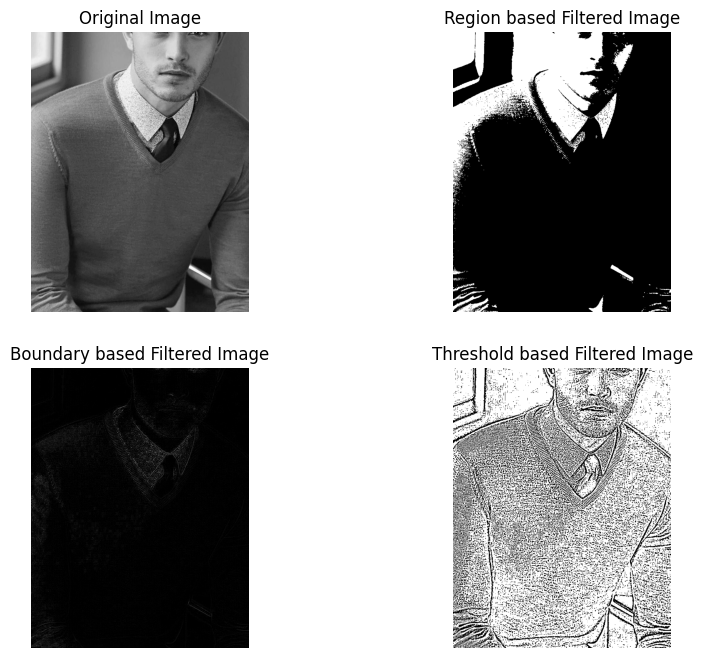

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image, technique):
    if technique == "region_based":
        # Apply region-based preprocessing technique (Segmentation)
        # Example: Simple thresholding
        _, filtered_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    elif technique == "boundary_based":
        # Apply boundary-based preprocessing technique
        # Example: Laplacian edge detection
        filtered_image = cv2.Laplacian(image, cv2.CV_8U)
    elif technique == "threshold_based":
        # Apply threshold-based preprocessing technique
        # Example: Adaptive thresholding
        filtered_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    elif technique == "watershed":
        # Apply watershed preprocessing technique
        # Example: Watershed segmentation
        _, filtered_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        # Morphological operations to clean up image
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(filtered_image, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        _, markers = cv2.connectedComponents(sure_fg)
        markers += 1
        markers[unknown == 255] = 0
        filtered_image = cv2.watershed(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), markers)
        filtered_image[markers == -1] = [255, 0, 0]  # Mark watershed boundaries
    else:
        raise ValueError("Invalid preprocessing technique provided")

    return filtered_image

# Load image
image = cv2.imread("crop.jpg", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

# List of preprocessing techniques
techniques = ["region_based", "boundary_based", "threshold_based", "watershed"]

# Create subplot
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
if image.dtype != np.uint8:
    image = np.uint8(image)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Apply and display each preprocessing technique
for i, technique in enumerate(techniques):
    filtered_image = preprocess_image(image, technique)
    plt.subplot(2, 2, i+2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(technique.replace("_", " ").capitalize() + ' Filtered Image')
    plt.axis('off')

plt.tight_layout()
plt.show()


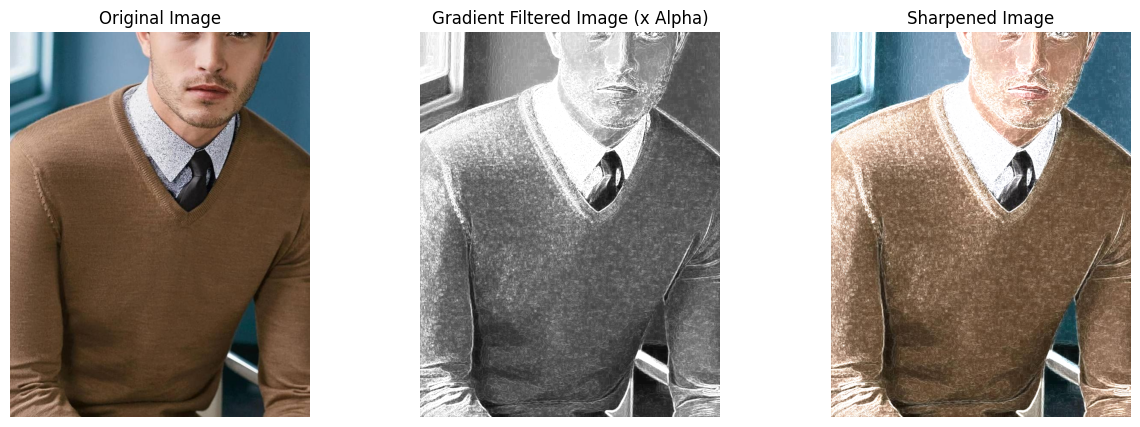

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sharpen_with_gradient(image, alpha=1.5):
    # Convert the RGB image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a gradient filter (Sobel) to the grayscale image
    gradient_x = cv2.Sobel(grayscale_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(grayscale_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Multiply the gradient filtered image by the parameter
    sharpened_image = alpha * gradient_magnitude
    
    # Convert back to uint8 and clip values greater than 255
    sharpened_image = np.clip(sharpened_image, 0, 255).astype(np.uint8)
    
    # Add the sharpened image to the original RGB image
    sharpened_rgb = cv2.addWeighted(image, 1, cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2BGR), 1, 0)
    
    return sharpened_rgb

# Load the RGB image
image = cv2.imread("crop.jpg")

# Set alpha value for sharpening
alpha = 1.5

# Apply sharpening with gradient filter and add to original image
sharpened_image = sharpen_with_gradient(image, alpha=alpha)

# Create a 1x3 subplot
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Gradient filtered image multiplied by alpha
plt.subplot(1, 3, 2)
gradient_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gradient_image, cmap='gray')
plt.title("Gradient Filtered Image (x Alpha)")
plt.axis('off')

# Added image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.title("Sharpened Image")
plt.axis('off')

plt.show()
